# Regrid SSH from Aviso

This notebook documents the steps needed to regrid Aviso datasets into a nominal 1/4 deg MOM grid (tx1_4).

In [1]:
%matplotlib inline

In [2]:
import xarray as xr
import xesmf
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
fname = '../mesh/tx1_4_grid.nc'
ds_out = xr.open_dataset(fname).rename({'tlon': 'lon','tlat': 'lat', 'qlon': 'lon_b','qlat': 'lat_b',})
ds_out

<xarray.Dataset>
Dimensions:  (ny: 1080, nx: 1440, nxp: 1441, nyp: 1081)
Dimensions without coordinates: ny, nx, nxp, nyp
Data variables: (12/20)
    lon      (ny, nx) float64 ...
    lat      (ny, nx) float64 ...
    ulon     (ny, nxp) float64 ...
    ulat     (ny, nxp) float64 ...
    vlon     (nyp, nx) float64 ...
    vlat     (nyp, nx) float64 ...
    ...       ...
    tarea    (ny, nx) float64 ...
    tmask    (ny, nx) float64 ...
    angle    (ny, nx) float64 ...
    depth    (ny, nx) float64 ...
    ar       (ny, nx) float64 ...
    egs      (ny, nx) float64 ...
Attributes:
    Description:  CESM MOM6 1/4 degree grid
    Author:       Frank, Fred, Gustavo (gmarques@ucar.edu)
    Created:      2022-12-27T10:20:11.076318
    type:         Glogal 1/4 degree grid file

### Mean sea level anomaly

In [4]:
infile = '/glade/campaign/cgd/oce/datasets/obs/aviso/mean_sea_level_anomaly/dt_global_allsat_msla_h_*'
ds_in = xr.open_mfdataset(infile)

In [5]:
ds_in

<xarray.Dataset>
Dimensions:           (time: 312, nv: 2, lat: 720, lon: 1440)
Coordinates:
  * time              (time) datetime64[ns] 1993-01-15 1993-02-15 ... 2018-12-15
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon               (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * nv                (nv) int32 0 1
Data variables:
    climatology_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds          (time, lat, nv) float32 dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
    lon_bnds          (time, lon, nv) float32 dask.array<chunksize=(1, 1440, 2), meta=np.ndarray>
    crs               (time) int32 -2147483647 -2147483647 ... -2147483647
    sla               (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/39)
    cdm_data_type:                   Grid
    comment:                         Monthly Mean of Sea Level Anomalies refe...
    date_issued:                     2018-02-13 16:54:24Z
    time_coverage_resolution:        P1M
    creator_email:                   aviso@altimetry.fr
    product_version:                 5.10
    ...                              ...
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         0.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    geospatial_lat_resolution:       0.25
    geospatial_lon_resolution:       0.25

In [6]:
sla_std = ds_in.sla.std('time').load()

/glade/work/gmarques/miniconda/envs/omwg_dev/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


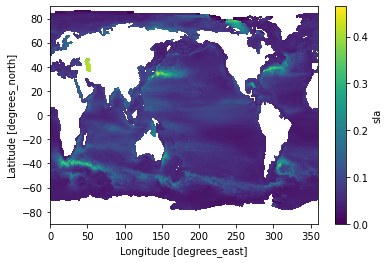

In [7]:
sla_std.plot()

In [8]:
def regrid_tracer(ds_in, ds_out, method='bilinear'):

    regrid = xesmf.Regridder(
        ds_in,
        ds_out,
        method=method,
        periodic=True,
    )
    fld_out = regrid(ds_in)
    return fld_out

In [9]:
sla_std_regrid = regrid_tracer(sla_std, ds_out).rename('ssh_std')

/glade/work/gmarques/miniconda/envs/omwg_dev/lib/python3.8/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Text(0.5, 1.0, 'Original grid')

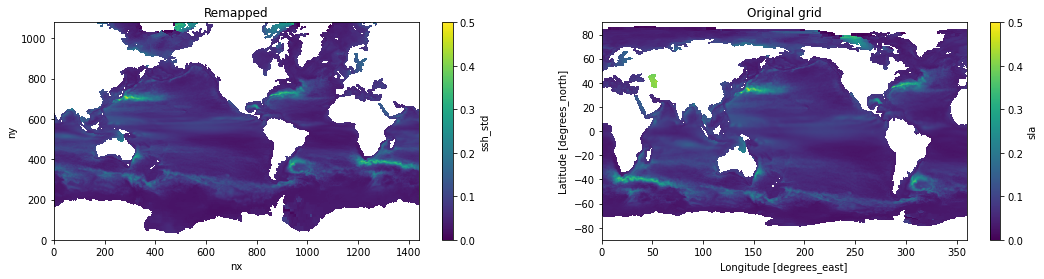

In [10]:
# visual inspection. Make sure original and remapped plots look similar
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,4))
sla_std_regrid.where(ds_out.tmask==1.).plot.pcolormesh(ax=axes[0], vmin=0,vmax=0.5)
sla_std.plot.pcolormesh(ax=axes[1], vmin=0,vmax=0.5)
axes[0].set_title('Remapped')
axes[1].set_title('Original grid')

In [11]:
# Global attrs
sla_std_regrid.attrs['title'] = 'Sea surface high standard deviation calculated from monthly means sla from AVISO and remapped to tx1_4.'
sla_std_regrid.attrs['start_time'] = str(ds_in.time[0].values)
sla_std_regrid.attrs['end_time'] = str(ds_in.time[-1].values)
sla_std_regrid.attrs['author'] = 'Gustavo Marques (gmarques@ucar.edu)'
sla_std_regrid.attrs['date'] = datetime.now().isoformat()
sla_std_regrid.attrs['infile'] = infile
sla_std_regrid.attrs['url'] = 'https://github.com/NCAR/tx1_4/ssh/'
# save
fname = 'ssh_std_aviso_to_tx1_4.nc'
sla_std_regrid.to_netcdf(fname)

### Mean sea surface height above geoid
The absolute dynamic topography is the sea surface height above geoid; the adt is obtained as follows: adt=sla+mdt where mdt is the mean dynamic topography; see the product user manual for details


In [12]:
infile = '/glade/campaign/cgd/oce/datasets/obs/aviso/mean_sea_level/dt_global_allsat_phy_l4_*.nc'
ds_in = xr.open_mfdataset(infile)

In [14]:
adt_mean = ds_in.adt.mean('time').load()

In [ ]:
adt_mean_regrid = regrid_tracer(adt_mean, ds_out).rename('adt_mean')

/glade/work/gmarques/miniconda/envs/omwg_dev/lib/python3.8/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [ ]:
# visual inspection. Make sure original and remapped plots look similar
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,4))
adt_mean_regrid.where(ds_out.tmask==1.).plot.pcolormesh(ax=axes[0], vmin=-1,vmax=1)
adt_mean.plot.pcolormesh(ax=axes[1], vmin=-1,vmax=1)
axes[0].set_title('Remapped')
axes[1].set_title('Original grid');

In [ ]:
# Global attrs
adt_mean_regrid.attrs['title'] = 'Mean sea surface height above geoid from AVISO remapped to tx1_4.'
adt_mean_regrid.attrs['start_time'] = str(ds_in.time[0].values)
adt_mean_regrid.attrs['end_time'] = str(ds_in.time[-1].values)
adt_mean_regrid.attrs['author'] = 'Gustavo Marques (gmarques@ucar.edu)'
adt_mean_regrid.attrs['date'] = datetime.now().isoformat()
adt_mean_regrid.attrs['infile'] = infile
adt_mean_regrid.attrs['url'] = 'https://github.com/NCAR/tx1_4/ssh/'
# save
fname = 'adt_mean_aviso_to_tx1_4.nc'
adt_mean_regrid.to_netcdf(fname)